## Imports and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import acf, plot_acf, pacf, plot_pacf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

import warnings
warnings.filterwarnings("ignore")

In [2]:
by_days = pd.read_pickle('data/sales_by_day.pkl')
by_days.head()

order_date
2015-01-01    2713.85
2015-01-02    2731.90
2015-01-03    2662.40
2015-01-04    1755.45
2015-01-05    2065.95
Name: total_price, dtype: float64

In [3]:
by_days.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 365 entries, 2015-01-01 to 2015-12-31
Series name: total_price
Non-Null Count  Dtype  
--------------  -----  
365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


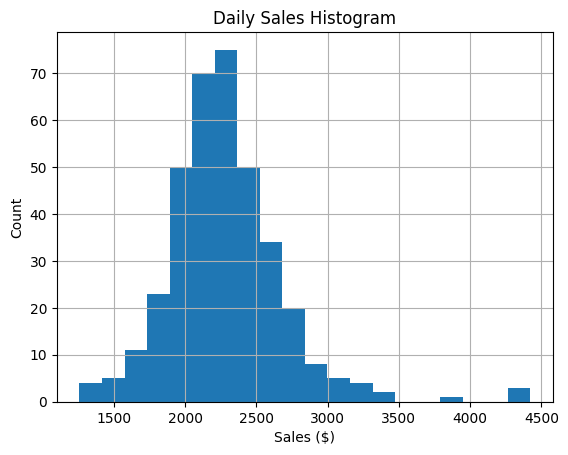

In [4]:
# View the histogram of sales to get a sense of the distribution of the sample.
by_days.hist(bins = 20)
plt.title('Daily Sales Histogram')
plt.xlabel('Sales ($)')
plt.ylabel('Count')
plt.show()

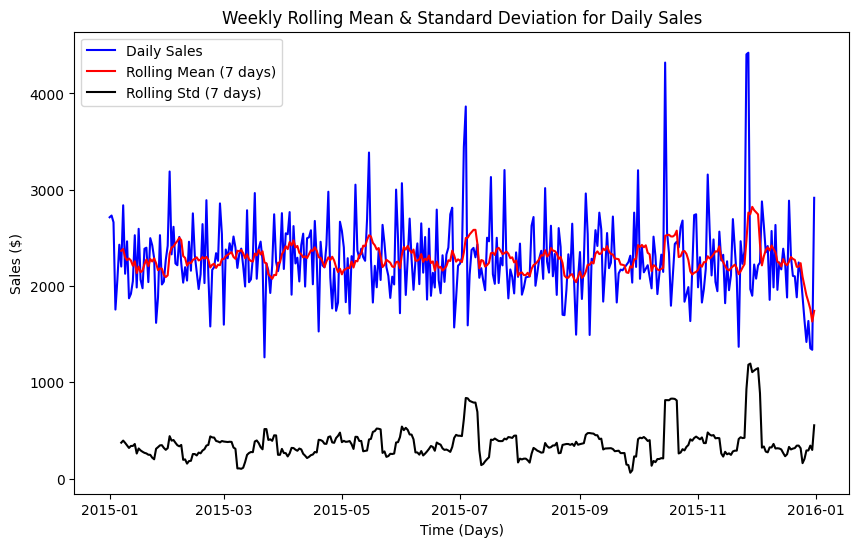

In [5]:
# Line plot of the total daily sales for the whole range of data: the year of 2015
# Also included is the rolling average of sales and the rolling standard deviation of sales taken over a moving one week window
rolmean = by_days.rolling(window = 7).mean()
rolstd = by_days.rolling(window = 7).std()

fig = plt.figure(figsize=(10, 6))
orig = plt.plot(by_days, color='blue',label='Daily Sales')
mean = plt.plot(rolmean, color='red', label='Rolling Mean (7 days)')
std = plt.plot(rolstd, color='black', label = 'Rolling Std (7 days)')
plt.legend(loc='best')
plt.title('Weekly Rolling Mean & Standard Deviation for Daily Sales')
plt.xlabel('Time (Days)')
plt.ylabel('Sales ($)')
plt.savefig('rolling_stats')
plt.show()

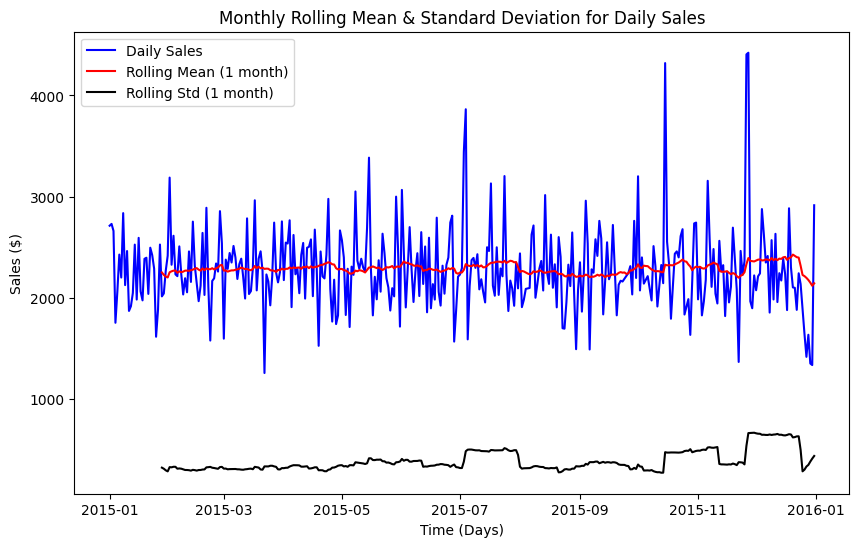

In [6]:
# Look at the above but with a rolling window of 28 days
rolmean = by_days.rolling(window = 28).mean()
rolstd = by_days.rolling(window = 28).std()

fig = plt.figure(figsize=(10, 6))
orig = plt.plot(by_days, color='blue',label='Daily Sales')
mean = plt.plot(rolmean, color='red', label='Rolling Mean (1 month)')
std = plt.plot(rolstd, color='black', label = 'Rolling Std (1 month)')
plt.legend(loc='best')
plt.title('Monthly Rolling Mean & Standard Deviation for Daily Sales')
plt.xlabel('Time (Days)')
plt.ylabel('Sales ($)')
plt.show()

To model a time series with the ARIMA family of models, you must determine certain orders to pass into the ARIMA function. These orders include integers for the autoregressive (AR) and moving average (MA) components of the ARIMA model. To determine those, we examine the autocorrelation function, partial autocorrelation function, and seasonal decomposition plots.

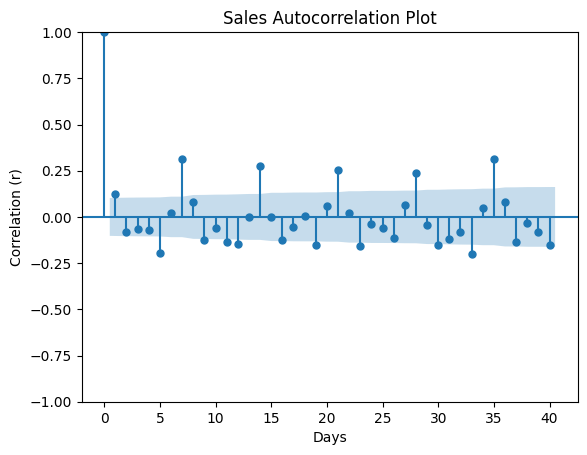

In [7]:
# Autocorrelation for data downsampled to daily. See up to 40 days
plot_acf(by_days, lags = 40)
plt.xlabel('Days')
plt.ylabel('Correlation (r)')
plt.title('Sales Autocorrelation Plot')
plt.show()

In [8]:
(np.sort(acf(by_days, nlags=80))[::-1] * 100).round(1)

array([100. ,  34.7,  31.6,  31.3,  28.3,  27.8,  26.2,  25.2,  24. ,
        23.9,  22.5,  21.8,  12.5,   8.9,   8.5,   8.2,   8. ,   7.7,
         7.5,   7.4,   6.6,   5.7,   5.1,   5. ,   4.4,   4.3,   3.8,
         3.2,   2.2,   2.1,   1.4,   0.4,   0.4,   0.1,  -0. ,  -0.2,
        -0.8,  -2. ,  -3.1,  -3.3,  -3.3,  -3.8,  -4.3,  -5.7,  -6.1,
        -6.2,  -6.3,  -6.5,  -6.6,  -6.8,  -7.6,  -8.1,  -8.2,  -8.4,
        -8.7,  -8.7,  -9.3,  -9.6, -10. , -10.9, -11.1, -11.5, -11.6,
       -11.8, -12. , -12.3, -12.3, -12.6, -12.9, -13.4, -13.7, -14.6,
       -15. , -15.3, -15.4, -15.6, -15.9, -17.2, -19.2, -19.7, -20.1])

We see a sharp drop after day one. The first value of an autocorrelation plot will always be 1, of course, as the first value has 100% correlation with itself. After that the autocorrelation drops below the band of statistical significance except for every 7 days and questionably every 5 days. What this is suggesting is that values in one week periods after the first value have a decent degree of autocorrelation with the first value (about +/- 30% to 20%). Or, in other words, you may be able to predict today's sales from the sales one week ago, or two weeks ago, or three weeks ago, etc. Next we look at the partial autocorrelation plots.

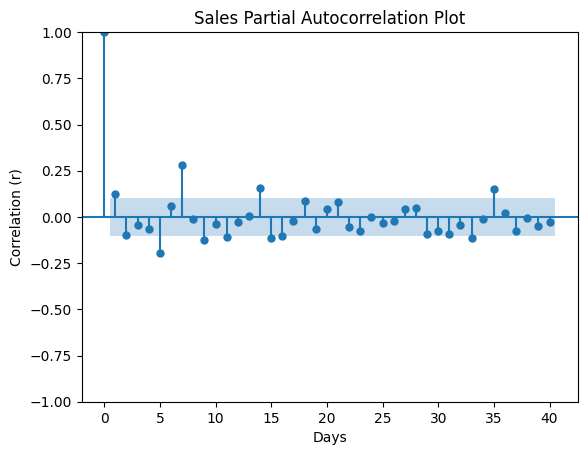

In [9]:
# Parital autocorrelation for data downsampled to daily. See up to 40 days
plot_pacf(by_days, lags = 40)
plt.xlabel('Days')
plt.ylabel('Correlation (r)')
plt.title('Sales Partial Autocorrelation Plot')
plt.show()

In [10]:
(np.sort(pacf(by_days, nlags=80))[::-1] * 100).round(1)

array([100. ,  28.6,  17.8,  16.4,  16.2,  12.6,  10.4,   9.9,   9.3,
         9. ,   7.9,   6.9,   6.3,   6.1,   6.1,   5.4,   4.7,   4.7,
         3.6,   3.6,   2.3,   1.9,   1.3,   0.5,   0.5,   0.5,   0.4,
         0.4,   0.4,   0.2,   0.1,   0. ,  -0.1,  -0.2,  -0.2,  -0.7,
        -0.8,  -0.9,  -1. ,  -1. ,  -1.1,  -1.3,  -2.1,  -2.2,  -2.2,
        -2.7,  -2.9,  -3.7,  -3.7,  -4. ,  -4.1,  -4.3,  -4.4,  -4.4,
        -4.5,  -5. ,  -5.2,  -5.6,  -5.7,  -6.1,  -6.4,  -6.8,  -7. ,
        -7.2,  -7.7,  -8.5,  -8.7,  -9.4,  -9.6,  -9.9,  -9.9, -10.1,
       -10.3, -10.6, -11. , -11.4, -12.2, -12.9, -13. , -13. , -19.8])

Partial autocorrelation functions (pacf) differ from autocorrelation functions in that the intervening days between a day and any other day are not considered in the correlation calculation. To clarify, when the normal autocorrelation (acf) above was found to be around 20 to 30% for each seven day period, those seven days periods were also considering day 2, 3, 4, 5, and 6. In a partial autocorrelation function, these intervening days are not considered. Again, the correlation is not better than about 30% and only after the first seven day period. 

Lastly, we take a look at the acf and pacf plots for the rolling 7 day variance of our daily sales. Mostly out of curiosity.

In [11]:
as_df = pd.DataFrame(by_days) # Change series to dataframe to use .rolling() method
roller = as_df.rolling(window = 7) # Create the rolling object with 7 day window
rolling_var = roller.var().dropna() # Apply variance function and drop null values

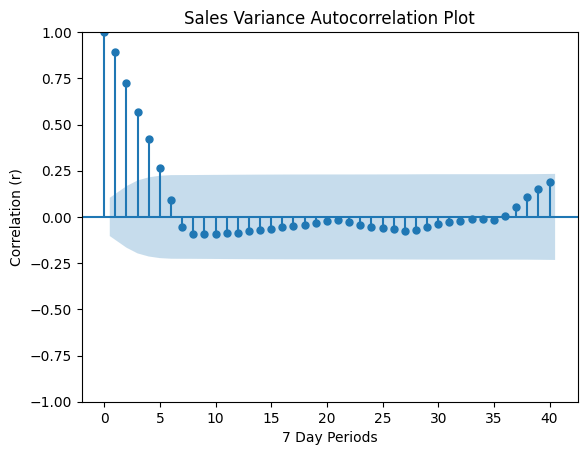

In [12]:
# Autocorrelation for variance in seven day rolling windows. See up to 40 one week periods
plot_acf(rolling_var, lags = 40)
plt.xlabel('7 Day Periods')
plt.ylabel('Correlation (r)')
plt.title('Sales Variance Autocorrelation Plot')
plt.show()

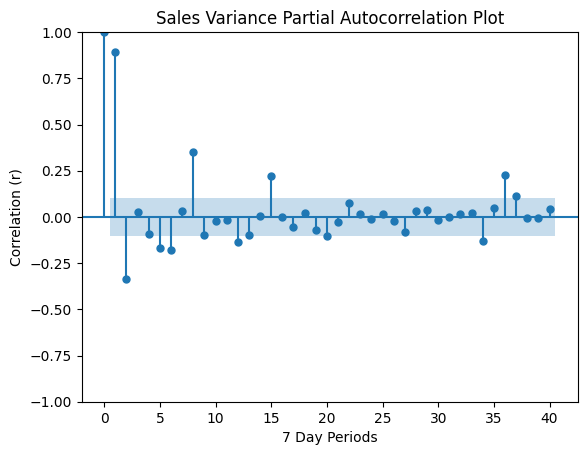

In [13]:
# Parital autocorrelation for variance in seven day rolling windows. See up to 40 one week periods
plot_pacf(rolling_var, lags = 40)
plt.xlabel('7 Day Periods')
plt.ylabel('Correlation (r)')
plt.title('Sales Variance Partial Autocorrelation Plot')
plt.show()

Now we turn to the seasonal decomposition plots. Seasonal decomposition means to decompose your time series into its component pieces: trend, seasonality, and its residuals. This is another tool to examine the nature of your time series and what kind of model orders you might choose for your ARIMA model.

<Figure size 640x480 with 0 Axes>

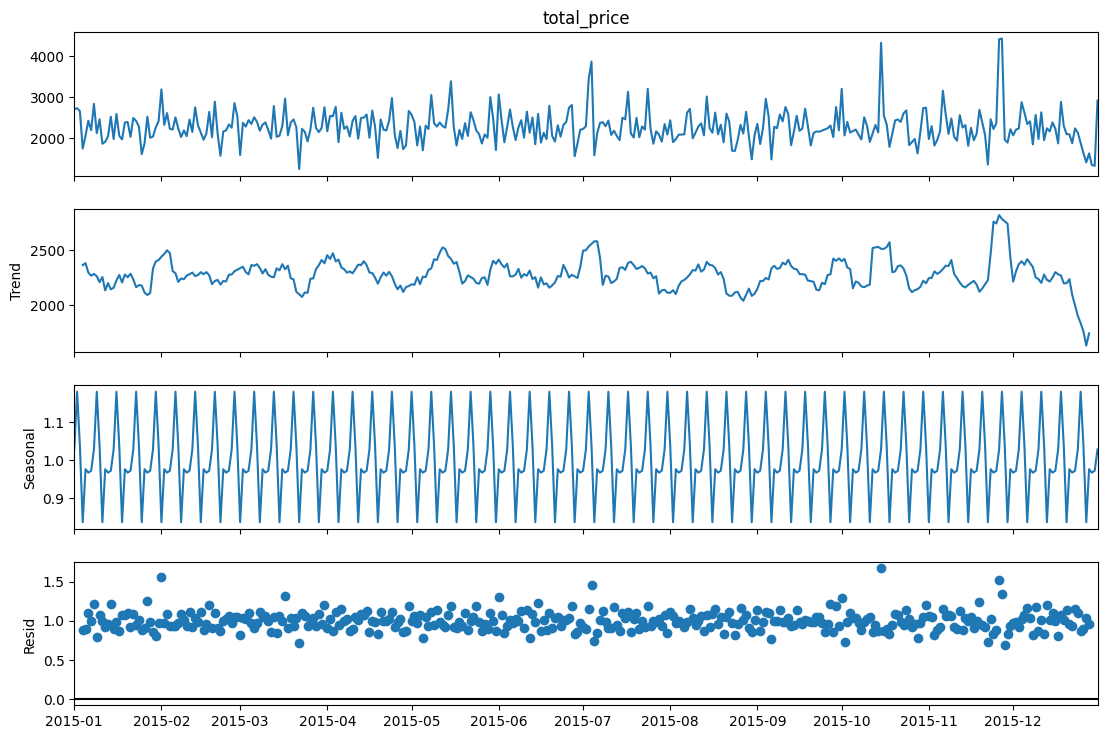

In [31]:
# Apply seasonal decomposition to data downsampled to daily
result = seasonal_decompose(by_days, model='multiplicative', period = 7) # Use 'multiplicative' for multiplicative model, period of 7 for seasonality

# trend = result.trend
# seasonal = result.seasonal
residual = result.resid

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(12, 8)
plt.show()

<Figure size 640x480 with 0 Axes>

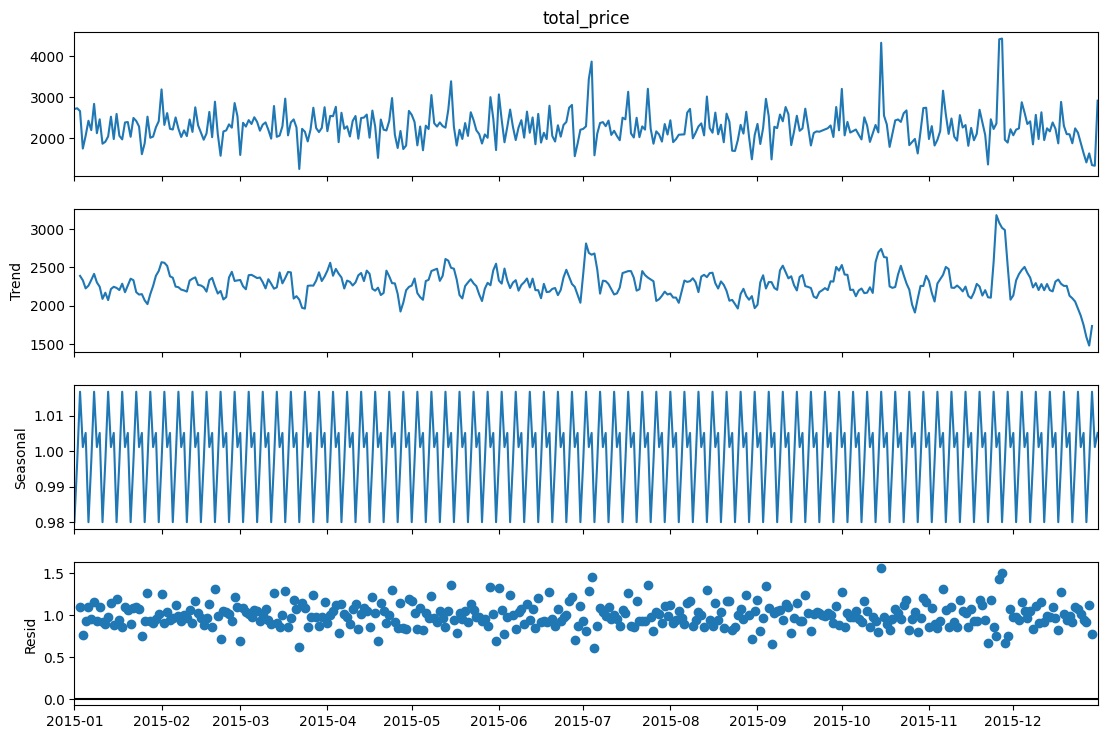

In [15]:
# Same as above with a periodicity of 5 days instead of 7
result = seasonal_decompose(by_days, model='multiplicative', period = 5) # Use 'multiplicative' for multiplicative model, check out period of 5

# trend = result.trend
# seasonal = result.seasonal
residual = result.resid

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(12, 8)
plt.show()

From the seasonal decomposition graph we can pretty clearly see there isn't much trend at all. We will run the Augmented Dickey-Fuller test to confirm this numerically.
### Augmented Dickey-Fuller Test
H0: The time series is non-stationary with respect to trend.

HA: The time series is stationary with respect to trend.

If the resulting p-value is low, below the significance threshold of 0.05, then we can reject the null hypothesis and embrace the alternate hypothesis.

In [16]:
# Augmented Dickey-Fuller test to statistically test for stationarity
p_value = adfuller(by_days)[1]
p_value

8.371402894907088e-06

The p-value is very close to zero. Therefore we can rejct H0 without fear of committing a Type I error, and conclude that the time series is stationary (has no trend). We will fit a linear model to see just how "unchanging" (i.e. not trending) the sales data is.

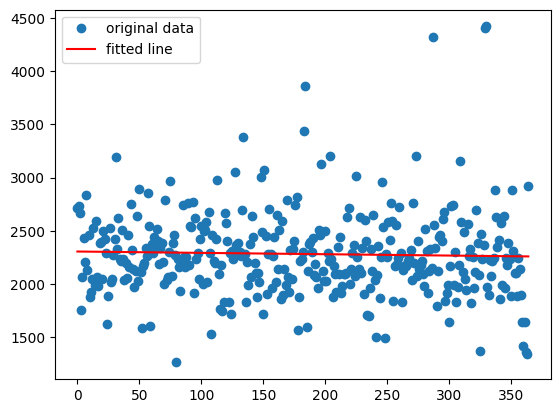

In [17]:
# Need to change index from datetime objects to ordinary numbers for OLS compuatations
for_linear_model = by_days.copy()
for_linear_model.reset_index(inplace = True, drop=True) # The old time series index is replaced by a simple integer index, but the order of the sales is preserved

res = stats.linregress(for_linear_model.index, for_linear_model) # Create linear model object
plt.plot(for_linear_model.index, for_linear_model, 'o', label='original data')
plt.plot(for_linear_model.index, res.intercept + res.slope*for_linear_model.index, 'r', label='fitted line')
plt.legend()
plt.show()

In [18]:
# Look at slope to see how close to zero it is
res.slope

-0.12660641177820617

Lastly, we'll use the Breusch-Pagan test to see if our variance is constant over time. This is the last piece of stationarity. We've looked at trend and determined there is none with various plots and the adf test, and we've looked at seasonality with various plots and found that there appears to be seasonality in seven day periods.

### Breusch-Pagan Test

H0: The time series has homoskedasticity (constant variance).

HA: The time series has heteroskedasticity (the variance is not constant).

If the resulting p-value is low, below the significance threshold of 0.05, then we can reject the null hypothesis and embrace the alternate hypothesis. In this particular case, we *want* homosketasticity, so we're hoping to find a p-value greater than our level of significance. 

In [65]:
# Run the regression model first to get residuals
X = sm.add_constant(np.array(for_linear_model.index))
y = by_days.values
model = sm.OLS(y, X).fit()

# Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'LM Statistic': 5.761185496560001, 'LM-Test p-value': 0.016384013763149515, 'F-Statistic': 5.821504388778283, 'F-Test p-value': 0.016326373606276635}


The p-value (the LM-Test p-value) is less than our significance threshold of 0.05! Therefore we can reject H0 without fear of committing a Type 1 error, which is not what we want. We want the null hypothesis to hold. It seems our time series is not stationary as is, and some modification must be made to achieve stationarity. There are some nasty outliers in our data, and we suspect they are the cause of the variance increasing at the later months of the data. Below we remove the outliers from the data and inspect stationarity.

In [20]:
# Calculate the 25th and 75th percentiles
Q1 = np.percentile(by_days, 25)
Q3 = np.percentile(by_days, 75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Calculate minimum and maximum thresholds for outliers
min_threshold = Q1 - (1.5 * IQR)
max_threshold = Q3 + (1.5 * IQR)
min_threshold, max_threshold

(1426.375, 3082.175)

In [21]:
# Filter out outliers. This will shorten the dataset. Need to add back in missing dates to get back to 365 days.
by_days_no_outliers = by_days[(by_days >= min_threshold) & (by_days <= max_threshold)]
len(by_days_no_outliers), len(by_days)

(349, 365)

In [22]:
# Reserve dates to create new date range with
min_date = by_days_no_outliers.index.min()
max_date = by_days_no_outliers.index.max()

In [23]:
# Isolate new date range and by_days_no_ouliers date range for comparison
complete_date_range = pd.date_range(min_date, max_date)
existing_dates = by_days_no_outliers.index

# Identify missing dates by comparing complete_date_range and existing_dates
missing_dates = complete_date_range.difference(existing_dates)

# Convert to list
missing_dates_list = missing_dates.tolist()
missing_dates_list

[Timestamp('2015-02-01 00:00:00'),
 Timestamp('2015-03-22 00:00:00'),
 Timestamp('2015-05-15 00:00:00'),
 Timestamp('2015-07-03 00:00:00'),
 Timestamp('2015-07-04 00:00:00'),
 Timestamp('2015-07-17 00:00:00'),
 Timestamp('2015-07-24 00:00:00'),
 Timestamp('2015-10-01 00:00:00'),
 Timestamp('2015-10-15 00:00:00'),
 Timestamp('2015-11-06 00:00:00'),
 Timestamp('2015-11-22 00:00:00'),
 Timestamp('2015-11-26 00:00:00'),
 Timestamp('2015-11-27 00:00:00'),
 Timestamp('2015-12-27 00:00:00'),
 Timestamp('2015-12-29 00:00:00'),
 Timestamp('2015-12-30 00:00:00')]

In [24]:
# Create a new entry (nan) in by_days_no_outliers for each of the dates it is missing
for missing_date in missing_dates:
    by_days_no_outliers[missing_date] = np.nan

# Sort, just in case
by_days_no_outliers.sort_index(inplace=True)

# Interpolate missing values using simple averaging of neighboring days
by_days_no_outliers.interpolate(method='time', inplace=True)

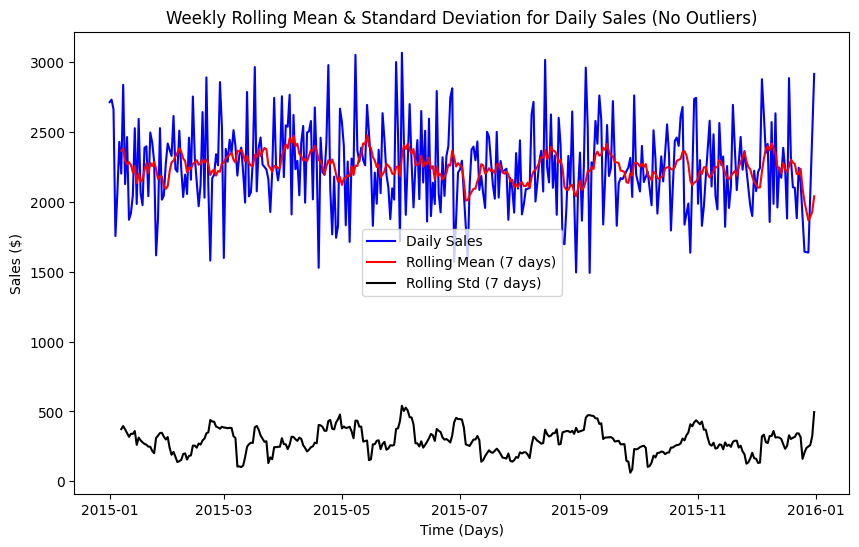

In [25]:
rolmean = by_days_no_outliers.rolling(window = 7).mean()
rolstd = by_days_no_outliers.rolling(window = 7).std()

fig = plt.figure(figsize=(10, 6))
orig = plt.plot(by_days_no_outliers, color='blue',label='Daily Sales')
mean = plt.plot(rolmean, color='red', label='Rolling Mean (7 days)')
std = plt.plot(rolstd, color='black', label = 'Rolling Std (7 days)')
plt.legend(loc='best')
plt.title('Weekly Rolling Mean & Standard Deviation for Daily Sales (No Outliers)')
plt.xlabel('Time (Days)')
plt.ylabel('Sales ($)')
plt.savefig('rolling_stats')
plt.show()

<Figure size 640x480 with 0 Axes>

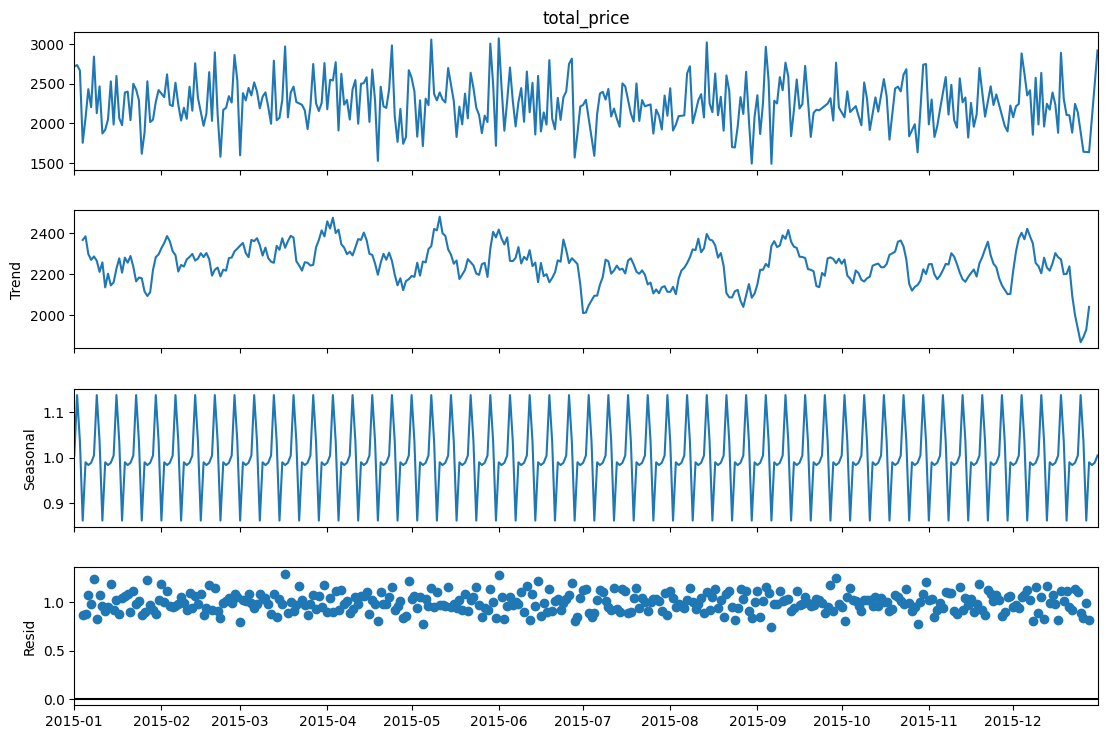

In [66]:
# Apply seasonal decomposition to data downsampled to daily
result = seasonal_decompose(by_days_no_outliers, model='multiplicative', period = 7) # Use 'multiplicative' for multiplicative model, period of 7 for seasonality

# trend = result.trend
# seasonal = result.seasonal
residual = result.resid

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(12, 8)
plt.show()

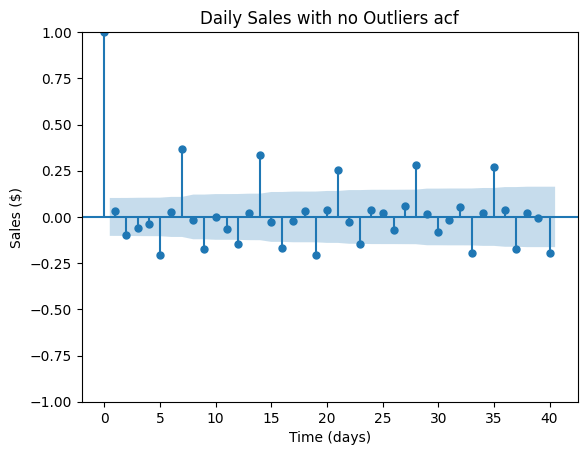

In [26]:
plot_acf(by_days_no_outliers, lags = 40)
plt.title('Daily Sales with no Outliers acf')
plt.xlabel('Time (days)')
plt.ylabel('Sales ($)')
plt.show()

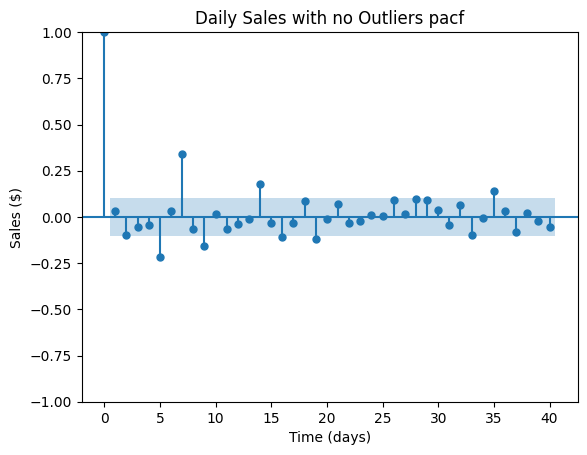

In [27]:
plot_pacf(by_days_no_outliers, lags = 40)
plt.title('Daily Sales with no Outliers pacf')
plt.xlabel('Time (days)')
plt.ylabel('Sales ($)')
plt.show()

That's looking way better already. Both the rolling mean and rolling variance plots appear way more constant, and from the acf and pacf plots we see that the weekly seasonality pattern is still present, although the pacf plot shows a trailing off into insignificance after 2 weekly periods. This suggests the MA order in the ARIMA model will be 2, but we'll cross that bridge when we come to it. We'll check the adf and BP tests again for safe measure.

In [28]:
# Augmented Dickey-Fuller test to statistically test for stationarity
p_value = adfuller(by_days_no_outliers)[1]
p_value

0.0009469549565102445

In [68]:
# Running a regression model
X = sm.add_constant(np.array(by_days_no_outliers.reset_index(drop=True).index))
y = by_days_no_outliers.values

model = sm.OLS(y, X).fit()
# Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))


{'LM Statistic': 0.0030851816828564305, 'LM-Test p-value': 0.9557047490342792, 'F-Statistic': 0.0030683025127147974, 'F-Test p-value': 0.9558564361597379}


A 0.95 p_value strongly suggests that to reject H0 would be to commit a Type 1 error, implying that the dataset does have a constant variance. The outlier free version of the data seems to be quite stationary in all respects.

In [30]:
# Pickle cleaned up dataframe and save for later
by_days_no_outliers.to_pickle('data/sales_by_day_no_outliers.pkl')